In [13]:
#importing useful libraries
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

#to ignore future warnings that comeup in the program
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [14]:
#specifying the image size
IMAGE_SIZE = [224, 224]

In [23]:
# creating dataset path from drive
train_path = '/content/drive/MyDrive/abcdfucku/training_metadata'
test_path = '/content/drive/MyDrive/abcdfucku/test_metadata'

In [24]:
#importing libraries to display the images
from PIL import Image 
import os 
from IPython.display import display
from IPython.display import Image as _Imgdis

# creating a object  
folder = train_path+'/Training set'

#list of all the images directries inside the train folder
onlytrainfiles = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
#specifying length of file
print("Working with {0} images".format(len(onlytrainfiles)))
print("Image examples: ")




Working with 420 images
Image examples: 


In [25]:
#displaying length of folder
len(onlytrainfiles)

420

image124.jpg


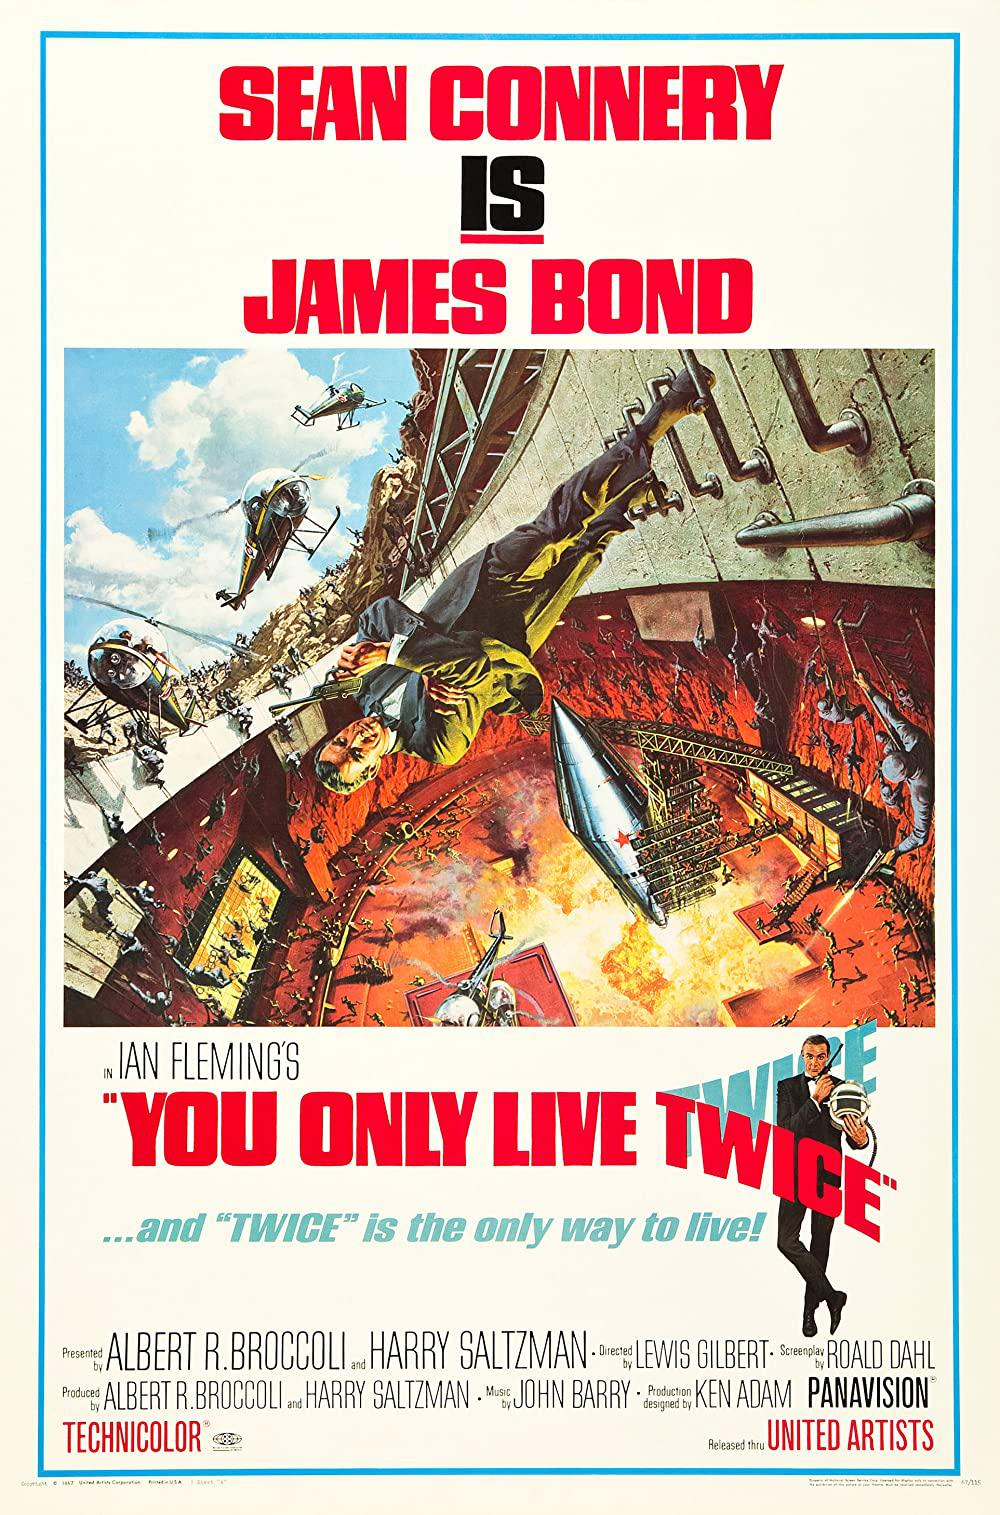

image12.jpg


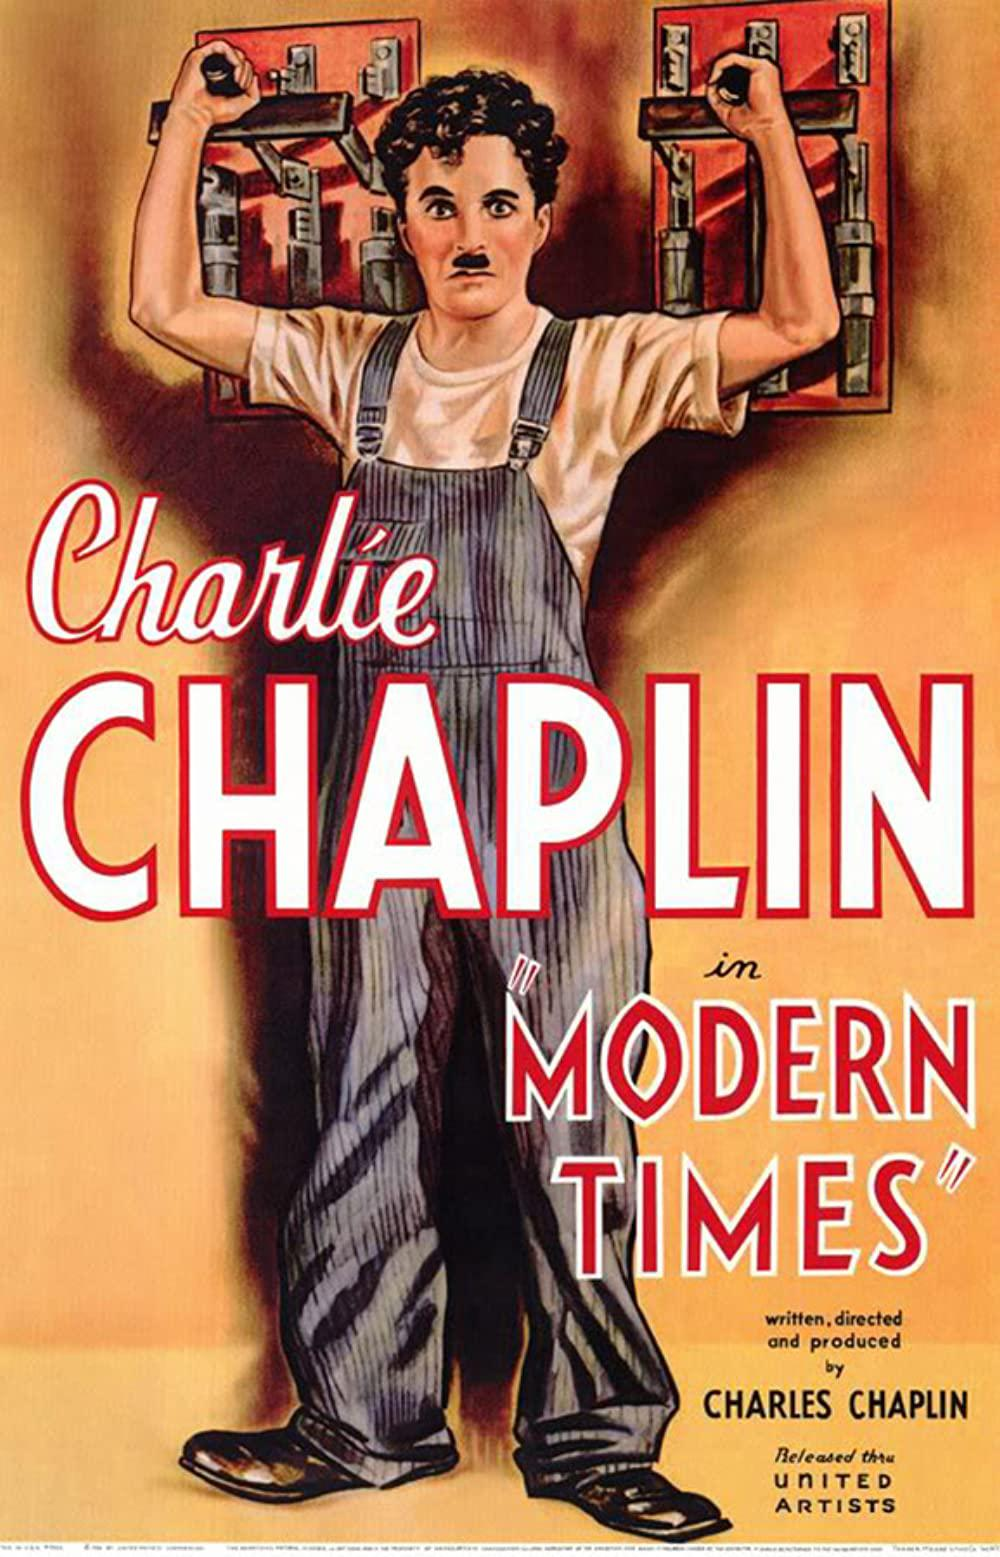

image121.jpg


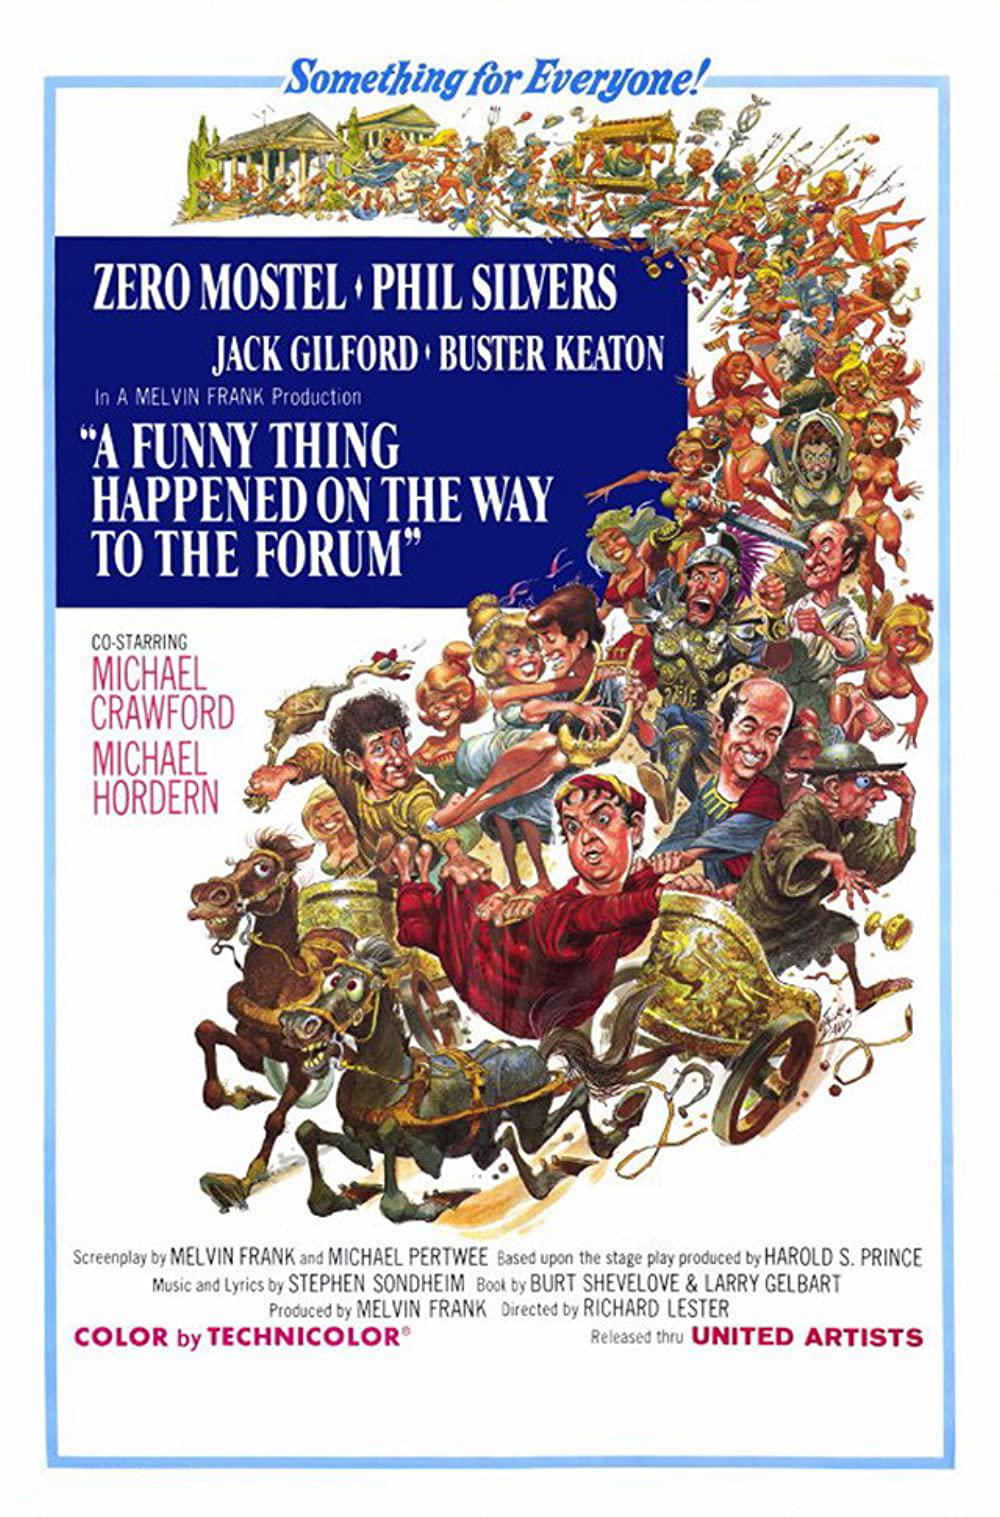

image120.jpg


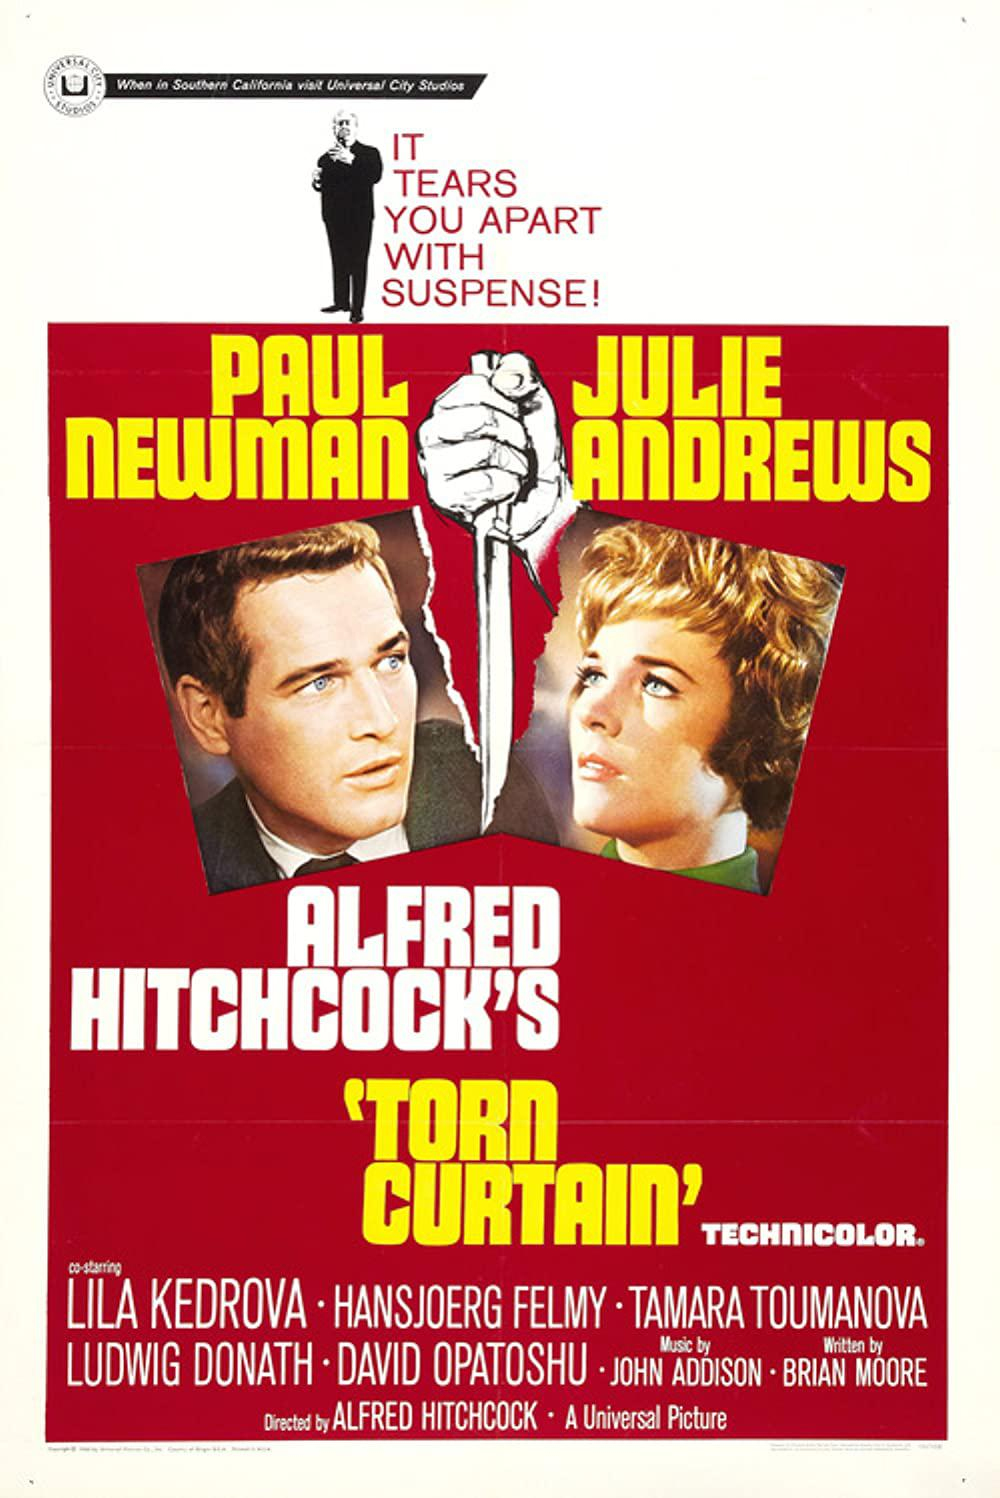

image123.jpg


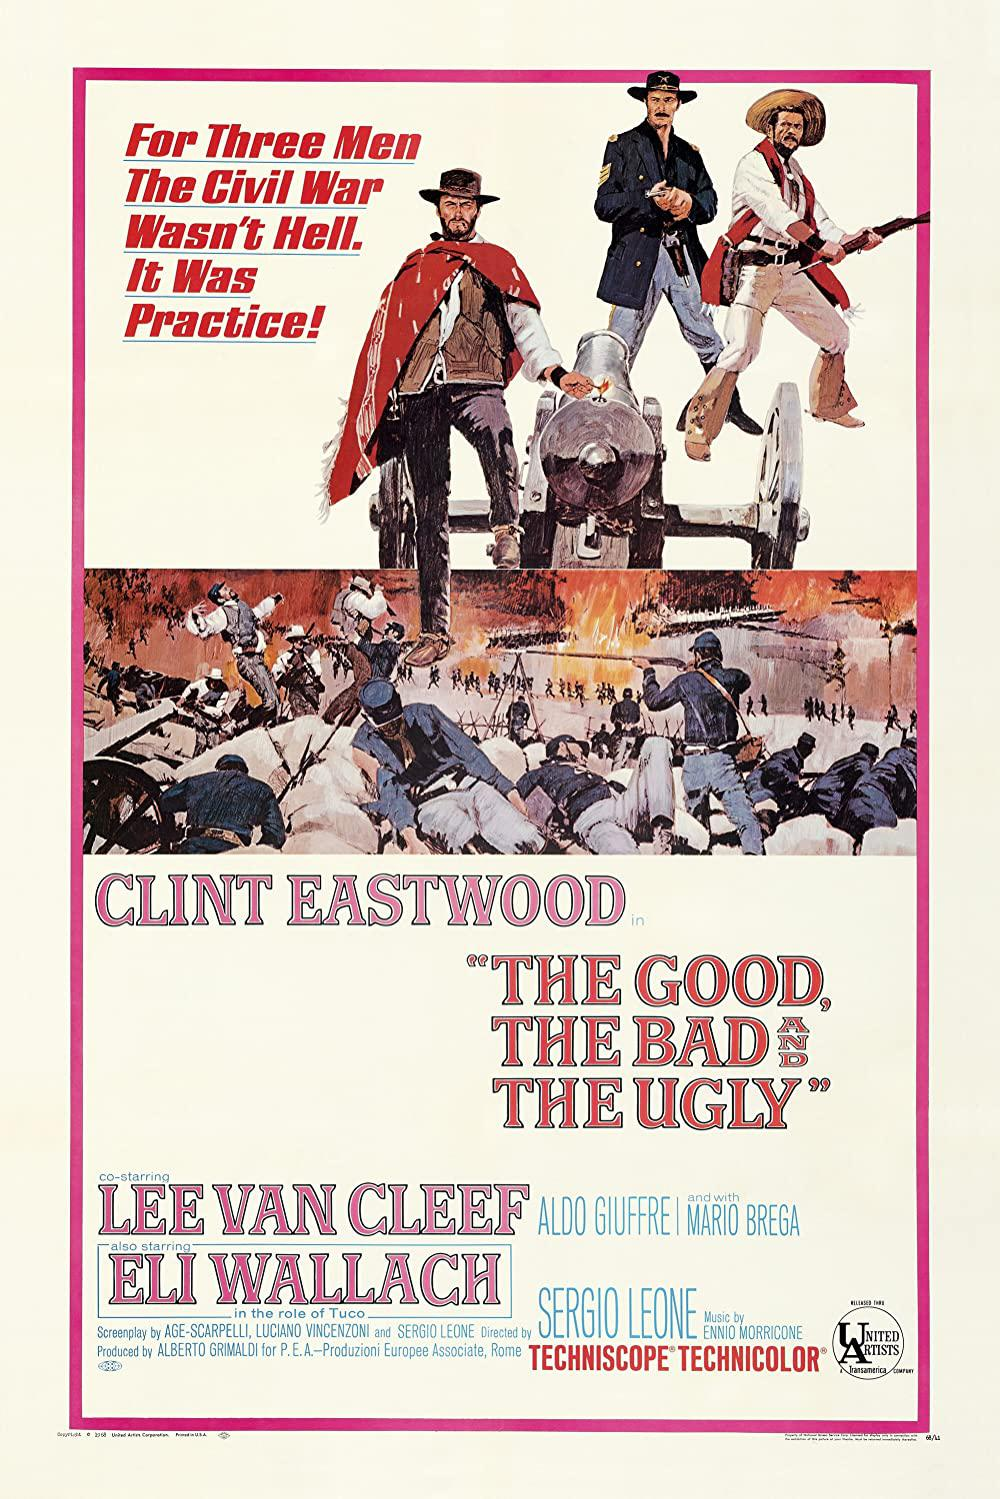

In [26]:
#displaying the images
for i in range(5):
    print(onlytrainfiles[i])
    display(_Imgdis(filename=folder + "/" + onlytrainfiles[i], width=240, height=240)) 

In [27]:
#calling keras model
#we're mentioning the input_shape=IMAGE_SIZE + [3] because it's a RGB image, weights = 'imagenet'(weights should be directly implemented from 
#image net classification), include_top=False(discard weights from input and output layers, we'll  use our own input and output))
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [28]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [29]:
for layer in vgg.layers:
  layer.trainable = False
#for all the layers which are there in the VGG model do not train them again, instead directly use the parameters that the model has learnt    

In [30]:
#glob to see how many folders/files are there in a particular directory
folders = glob('/content/drive/MyDrive/abcdfucku/training_metadata/*')
print(len(folders))

1


In [31]:
#all  the outputs that we get in the last layer we condense them into 1D using flatten layer
#vgg.output takes the output from previous layer and use it to flatten upcoming layer
x = Flatten()(vgg.output)
#we need the neurons acc to the no.of classes(here len(folder)=1,neurons=1), activation='softmax'(general for many classes)
prediction = Dense(len(folders), activation='softmax')(x)
#model construction, input coming from VGG, output we just created from prediction
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
#we call adam optimiser to experiment with model
import tensorflow
from keras import optimizers
adam = tensorflow.optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [42]:
#image augmentation
# preprocessing_function=preprocess_input because when the actual model was trained it had some preprocessing steps that were used,so to get the similar
#result we do exact same preprocessing step  
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #augmentation parameters
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [36]:
#same for test set
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [37]:
#train data generator, in target_size we do not mention 3rd dimension,it'll automatically figure it out
#batch_size = 32(at a time model will train batches of 32)
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 420 images belonging to 1 classes.


In [38]:
#similar as training set
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 180 images belonging to 1 classes.


In [40]:
#train the model
from datetime import datetime
from keras.callbacks import ModelCheckpoint


#ModelCheckpoint to save the best model
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]
#to keep the track of how much time the training process took
start = datetime.now()
#over here we are training the model
#verbose tells about how much information we get printed during printing the model
model_history=model.fit_generator(
  train_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=5,
  validation_steps=32,
    callbacks=callbacks ,verbose=2)

#this is just to print the duration of training of model
duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10

Epoch 1: val_loss improved from inf to 0.00000, saving model to mymodel.h5
2/2 - 135s - loss: 1.0297e-14 - accuracy: 1.0000 - val_loss: 6.8159e-29 - val_accuracy: 1.0000 - 135s/epoch - 68s/step
Epoch 2/10
2/2 - 33s - loss: 2.4620e-34 - accuracy: 1.0000 - 33s/epoch - 16s/step
Epoch 3/10
2/2 - 32s - loss: 0.0000e+00 - accuracy: 1.0000 - 32s/epoch - 16s/step
Epoch 4/10
2/2 - 32s - loss: 0.0000e+00 - accuracy: 1.0000 - 32s/epoch - 16s/step
Epoch 5/10
2/2 - 32s - loss: 0.0000e+00 - accuracy: 1.0000 - 32s/epoch - 16s/step
Epoch 6/10
2/2 - 32s - loss: 0.0000e+00 - accuracy: 1.0000 - 32s/epoch - 16s/step
Epoch 7/10
2/2 - 31s - loss: 0.0000e+00 - accuracy: 1.0000 - 31s/epoch - 16s/step
Epoch 8/10
2/2 - 32s - loss: 0.0000e+00 - accuracy: 1.0000 - 32s/epoch - 16s/step
Epoch 9/10
2/2 - 32s - loss: 0.0000e+00 - accuracy: 1.0000 - 32s/epoch - 16s/step
Epoch 10/10
2/2 - 34s - loss: 0.0000e+00 - accuracy: 1.0000 - 34s/epoch - 17s/step
Training completed in time:  0:07:40.585851


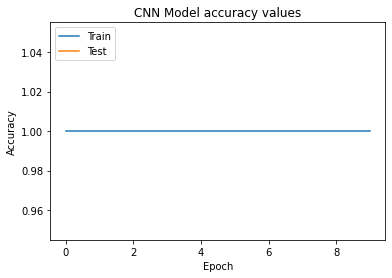

In [41]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
